### Vorticity balance in Ross Sea region

This notebook is for analysing depth-integrated vorticity budget terms in the Ross sea region. The intent is to understand the main balances in this region in a hirarchy of model resolutions.

In a steady state, the following balance holds

\begin{equation}
\beta \overline{\int_{-H}^{\eta}vdz} = \dfrac{1}{\rho_o}\overline{J(p_b, H)} - \overline{\dfrac{fQ_m}{\rho_o}} + \dfrac{1}{\rho_o}\nabla \wedge\overline{\left(\boldsymbol{\tau_s - \tau_b}\right)} + \overline{\nabla \wedge \int_{-H}^{\eta}\mathbf{a}dz} + \overline{\nabla \wedge \int_{-H}^{\eta}\mathbf{b}dz} \tag{1}
\end{equation}

\begin{equation}
\beta \overline{V} = \dfrac{1}{\rho_o}\overline{J(p_b, H)} - f\overline{\dfrac{Q_m}{\rho_o}} + \dfrac{1}{\rho_o}\nabla \wedge\overline{\left(\boldsymbol{\tau_s - \tau_b}\right)} + \overline{\nabla \wedge \mathcal{A}} + \overline{\nabla \wedge \mathcal{B}} \tag{2}
\end{equation}

It is seen that, in addition to boundary stress terms (third term on the RHS), bottom pressure torque (first term on the RHS) and nonlinear terms (fourth term on the RHS) do contribute significantly to the overall vorticity baalnce. Here, we isolate the relative contributions of these terms in 1/8 deg MOM6 simulation.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
import filter
from dask.diagnostics import ProgressBar
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

In [3]:
# Filter set

def apply_gaussian_filter(field,wetMask,NL_g,sL_g,NB_g,sB_g):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_g):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_g[i])*tempL # Update filtered field
    for i in range(NB_g): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_g[i])/np.abs(sB_g[i])**2)*tempL + (1/np.abs(sB_g[i])**2)*tempB
        
    return fieldBar

def apply_taper_filter(field,wetMask,NL_t,sL_t,NB_t,sB_t):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_t):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_t[i])*tempL # Update filtered field
    for i in range(NB_t): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_t[i])/np.abs(sB_t[i])**2)*tempL + (1/np.abs(sB_t[i])**2)*tempB
        
    return fieldBar

def simple_Laplacian(phi,wetMask):
    np = _get_array_module(phi)

    out = phi.copy()
    out = np.nan_to_num(out) 
    out = wetMask * out 
    
    fac = (np.roll(wetMask, -1, axis=-1) 
            + np.roll(wetMask, 1, axis=-1) 
            + np.roll(wetMask, -1, axis=-2) 
            + np.roll(wetMask, 1, axis=-2)  
    )
        
    out = (- fac * out
            + np.roll(out, -1, axis=-1) 
            + np.roll(out, 1, axis=-1) 
            + np.roll(out, -1, axis=-2) 
            + np.roll(out, 1, axis=-2)
    )
        
    out = wetMask * out
    return out

try:
    from cupy import get_array_module as _get_array_module
except ImportError:
    import numpy as np

    def _get_array_module(*args):
        return np

# Laplacian steps: 18; # Biharmonic steps: 11


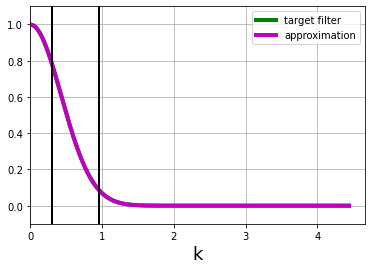

In [4]:
# Set Filter

# Guassian Filter set 

filter_fac = 8 # 1/8 --> 2 Deg

Lf_g = filter_fac/np.sqrt(6) 
N_g = 40
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

In [5]:
# Read data

ds = xr.open_dataset("/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Global_MOM6/v3/Mom_Budget_OM125_011601-012012.nc")

ds = ds.sel(yh = slice(0,80.), yq = slice(0,80.), xh = slice(-100, 10.), xq = slice(-100, 10.))

print(ds)

<xarray.Dataset>
Dimensions:             (xh: 835, xq: 835, yh: 964, yq: 964)
Coordinates:
  * xh                  (xh) float64 -99.93 -99.78 -99.63 ... 9.657 9.773 9.888
  * yh                  (yh) float64 0.0 0.125 0.25 0.375 ... 79.84 79.89 79.95
  * xq                  (xq) float64 -100.0 -99.85 -99.7 ... 9.657 9.773 9.888
  * yq                  (yq) float64 0.0625 0.1875 0.3125 ... 79.86 79.92 79.97
Data variables:
    hf_CAu_2d           (yh, xq) float64 ...
    hf_CAv_2d           (yq, xh) float64 ...
    hf_PFu_2d           (yh, xq) float64 ...
    hf_PFv_2d           (yq, xh) float64 ...
    hf_diffu_2d         (yh, xq) float64 ...
    hf_diffv_2d         (yq, xh) float64 ...
    hf_du_dt_visc_2d    (yh, xq) float64 ...
    hf_dudt_2d          (yh, xq) float64 ...
    hf_dv_dt_visc_2d    (yq, xh) float64 ...
    hf_dvdt_2d          (yq, xh) float64 ...
    hf_gKEu_2d          (yh, xq) float64 ...
    hf_gKEv_2d          (yq, xh) float64 ...
    hf_rvxu_2d          (yq, xh) f

In [6]:
# Double precision static file

ppdir = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_f8static/gfdl.ncrc4-intel18-prod-openmp/history/"
ds_grid = xr.open_dataset(ppdir + "01010101.ocean_static.nc")

ds_grid = ds_grid.isel(xq = slice(0,2880), yq=slice(0,2240))

ds_grid = ds_grid.drop('time')

ds_grid = ds_grid.sel(yh = slice(0,80.), yq = slice(0,80.), xh = slice(-100, 10.), xq = slice(-100, 10.))

In [7]:
print(ds_grid)

<xarray.Dataset>
Dimensions:       (xh: 835, xq: 835, yh: 964, yq: 964)
Coordinates:
  * xh            (xh) float64 -99.93 -99.78 -99.63 -99.48 ... 9.657 9.773 9.888
  * yh            (yh) float64 0.0 0.125 0.25 0.375 ... 79.78 79.84 79.89 79.95
  * xq            (xq) float64 -100.0 -99.85 -99.7 -99.55 ... 9.657 9.773 9.888
  * yq            (yq) float64 0.0625 0.1875 0.3125 0.4375 ... 79.86 79.92 79.97
Data variables:
    areacello     (yh, xh) float64 ...
    deptho        (yh, xh) float64 ...
    hfgeou        (yh, xh) float64 ...
    sftof         (yh, xh) float64 ...
    Coriolis      (yq, xq) float64 ...
    geolon        (yh, xh) float64 ...
    geolat        (yh, xh) float64 ...
    geolon_c      (yq, xq) float64 ...
    geolat_c      (yq, xq) float64 ...
    geolon_u      (yh, xq) float64 ...
    geolat_u      (yh, xq) float64 ...
    geolon_v      (yq, xh) float64 ...
    geolat_v      (yq, xh) float64 ...
    wet           (yh, xh) float64 ...
    wet_c         (yq, xq) floa

In [8]:
print(np.finfo(ds.intz_CAu_2d))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



In [15]:
print(np.finfo(ds_grid.dxCu))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



In [48]:
print(np.finfo(ds.dxCu))

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
---------------------------------------------------------------



#### Compute depth, beta at u, v points

In [10]:
# Create grid and interpolate depth, beta

OMEGA = 7.2921e-5
RAD_EARTH = 6.378e6

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=[ ])

depth_u = grid.interp(ds['deptho'] * ds_grid['areacello'], 'X',  boundary='fill')  / ds_grid['areacello_cu']
depth_v = grid.interp(ds['deptho'] * ds_grid['areacello'], 'Y',  boundary='fill') / ds_grid['areacello_cv']
depth_q = grid.interp(depth_u * ds_grid['areacello_cu'], 'Y',  boundary='fill') / ds_grid['areacello_bu']

colh_u = grid.interp(ds['col_height'] * ds_grid['areacello'], 'X',  boundary='fill') / ds_grid['areacello_cu']
colh_v = grid.interp(ds['col_height'] * ds_grid['areacello'], 'Y',  boundary='fill') / ds_grid['areacello_cv']

#beta_u =  grid.diff(ds['Coriolis'], 'Y',  boundary='fill') / ds_grid['dyCu']
#beta_v = grid.interp(grid.interp(beta_u, 'X',  boundary='fill'), 'Y',  boundary='fill')

beta_v = 2*OMEGA*np.cos(ds.geolat_v * np.pi /180.)/RAD_EARTH
beta_q = 2*OMEGA*np.cos(ds.geolat_c * np.pi /180.)/RAD_EARTH

#### Compute terms in vorticity budget

In [11]:
rho_0 = 1035.

BPT = xr.Dataset()

vmo_bv = (ds['vmo'] / (rho_0 * ds_grid['dxCv'])).load()
vmo_bv = beta_q * grid.interp(vmo_bv, 'X',  boundary='fill')

vmo_bv = vmo_bv.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

BPT_1 = ( - grid.diff((ds['intz_PFu_2d'] + ds['intz_u_BT_accel_2d']) * ds_grid.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_PFv_2d'] + ds['intz_v_BT_accel_2d']) * ds_grid.dyCv, 'X', boundary='fill') 
          ) / ds_grid.areacello_bu

%time BPT['BPT'] = (BPT_1.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

%time BPT['vmo_bv'] = (vmo_bv.load())

%time BPT['depth'] = (depth_q.load())

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 2.19 ms
CPU times: user 2 ms, sys: 5 ms, total: 7 ms
Wall time: 102 ms
CPU times: user 1e+03 µs, sys: 0 ns, total: 1e+03 µs
Wall time: 1.08 ms


In [23]:
# Compute BPT with double precision static file

BPT_2 = ( - grid.diff((ds['intz_PFu_2d'] + ds['intz_u_BT_accel_2d']) * ds_grid.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_PFv_2d'] + ds['intz_v_BT_accel_2d']) * ds_grid.dyCv, 'X', boundary='fill') 
          ) / ds_grid.areacello_bu

BPT_2 = BPT_2.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

In [33]:
print(np.finfo(BPT_2))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



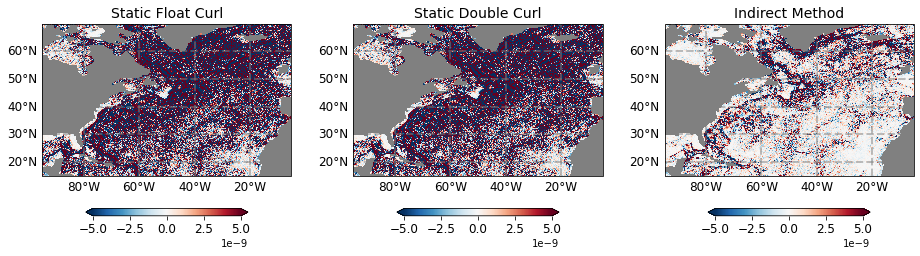

In [39]:
max_r = 5.e-9
lat_lon_ext = [-95., -5., 15., 70.]

grid1 = plt.GridSpec(1, 3, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[16,4])

BPT1 = BPT['BPT'] + BPT['Curl_Cor'] + BPT['vmo_bv'] + BPT['Qm']
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['BPT'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Static Float Curl')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_2, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Static Double Curl')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Indirect Method')

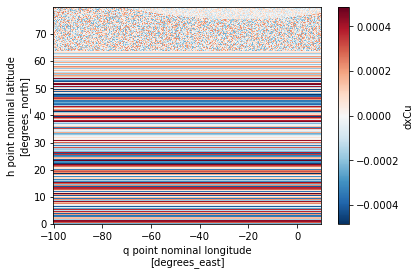

In [42]:
(ds_grid.dxCu - ds.dxCu).plot()

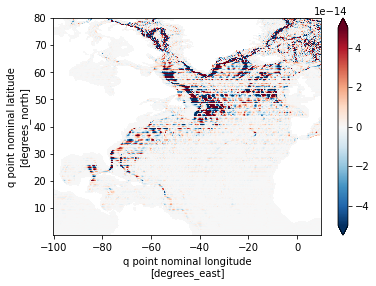

In [47]:
(BPT_2 - BPT['BPT']).plot(vmin=-5.e-14,vmax=5.e-14,cmap='RdBu_r')

#### Compute all terms

In [27]:
# area-weighted interpolation prefer
Mass_Surf = (grid.interp(grid.interp(ds['wfo'] * ds_grid['areacello'], 'X', boundary='fill'), 'Y',  boundary='fill') 
             * ds['Coriolis'] / (rho_0)) / ds_grid['areacello_bu']
Mass_Surf = Mass_Surf.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

%time BPT['Qm'] = - Mass_Surf.load()

dhdt = (grid.interp(grid.interp(ds['zos'] * ds_grid['areacello'], 'X', boundary='fill'), 'Y',  boundary='fill') 
             * ds['Coriolis']) / ds_grid['areacello_bu']
dhdt = dhdt.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

%time BPT['fdhdt'] = dhdt.load()

div_u = (grid.diff(ds['umo'] / (rho_0), 'X', boundary='fill') + 
         grid.diff(ds['vmo'] / (rho_0), 'Y', boundary='fill') ) / ds_grid['areacello']
div_u = - (grid.interp(grid.interp(div_u * ds_grid['areacello'], 'X', boundary='fill'), 'Y', boundary='fill')
        * ds['Coriolis']) / ds_grid['areacello_bu'] 
%time BPT['div_u'] = div_u.load()

Curl_dudt = ( - grid.diff(ds['hf_dudt_2d'] * colh_u * ds_grid['dxCu'], 'Y', boundary='fill')
            + grid.diff(ds['hf_dvdt_2d'] * colh_v * ds_grid['dyCv'], 'X', boundary='fill') ) / ds_grid.areacello_bu 
%time BPT['Curl_dudt'] = (Curl_dudt.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_taus = ( - grid.diff((ds['taux'])* ds_grid.dxCu, 'Y', boundary='fill')
                   + grid.diff((ds['tauy'])* ds_grid.dyCv, 'X', boundary='fill') )/ ds_grid.areacello_bu 
Curl_taus = Curl_taus / (rho_0 )
%time BPT['Curl_taus'] = (Curl_taus.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_taub = ( - grid.diff((-ds['taux_bot'])* ds_grid.dxCu, 'Y', boundary='fill')
                   + grid.diff(-ds['tauy_bot'] * ds_grid.dyCv, 'X', boundary='fill') )/ ds_grid.areacello_bu 
Curl_taub = Curl_taub / (rho_0 )
%time BPT['Curl_taub'] = (Curl_taub.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_Hrv2 = ( - grid.diff((ds['intz_rvxv_2d'] + ds['intz_gKEu_2d']) * ds_grid.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_rvxu_2d'] + ds['intz_gKEv_2d']) * ds_grid.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
%time BPT['Curl_NL'] = (Curl_Hrv2.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_Hdiff2 = ( - grid.diff(ds['intz_diffu_2d'] * ds_grid.dxCu, 'Y', boundary='fill')
             + grid.diff(ds['intz_diffv_2d'] * ds_grid.dyCv, 'X', boundary='fill') )/ ds_grid.areacello_bu 
%time BPT['Curl_Hdiff'] = (Curl_Hdiff2.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_Cor2 = ( - grid.diff((ds['intz_CAu_2d'] - ds['intz_gKEu_2d'] - ds['intz_rvxv_2d'])* ds_grid.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_CAv_2d'] - ds['intz_gKEv_2d'] - ds['intz_rvxu_2d'])* ds_grid.dyCv, 'X', boundary='fill'))/ ds_grid.areacello_bu
%time BPT['Curl_Cor'] = (Curl_Cor2.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

tmpx = (ds['hf_dudt_2d'] * colh_u - ds['intz_CAu_2d']-ds['intz_PFu_2d']-ds['intz_diffu_2d']-
       ds['intz_u_BT_accel_2d'] - ds['taux']/rho_0 + ds['taux_bot']/rho_0)
tmpy = (ds['hf_dvdt_2d'] * colh_v - ds['intz_CAv_2d']-ds['intz_PFv_2d']-ds['intz_diffv_2d']-
       ds['intz_v_BT_accel_2d'] - ds['tauy'] /rho_0 + ds['tauy_bot']/rho_0)
Curl_remap = ( - grid.diff(tmpx * ds_grid.dxCu, 'Y', boundary='fill')
             + grid.diff(tmpy * ds_grid.dyCv, 'X', boundary='fill') )/ ds_grid.areacello_bu 
%time BPT['Curl_remap'] = (Curl_remap.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

CPU times: user 6 ms, sys: 2 ms, total: 8 ms
Wall time: 7.38 ms
CPU times: user 4 ms, sys: 2 ms, total: 6 ms
Wall time: 5.81 ms
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 2.07 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.73 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.73 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.73 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.7 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.74 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.73 ms
CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 3.72 ms


#### Filter terms to remove noise

In [28]:
%%time

BPT_g = xr.Dataset() # new xarray dataset for Gaussian-filtered fields with Fixed (coarsening) Factor

fldlist = ['BPT','Curl_taus','Curl_taub','Curl_NL', 'Curl_remap', 'Curl_Cor',
           'Curl_Hdiff','vmo_bv','Qm','Curl_dudt', 'depth', 'fdhdt','div_u']
dims = ['yq', 'xq']

# Gaussian filter
for fld in fldlist: 
    
    dataBar = BPT[fld].copy() # Initialize the filtering process
    dataBar = dataBar * ds_grid['areacello_bu']

    dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_c'], NL_g, sL_g, NB_g, sB_g, 
                             input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                             output_dtypes=[dataBar.dtype], dask='parallelized')

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(ds['wet_c'],dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds_grid['areacello_bu'] # divide by cell area    

    BPT_g[fld] = dataBar.copy()

CPU times: user 12.2 s, sys: 648 ms, total: 12.9 s
Wall time: 12.9 s


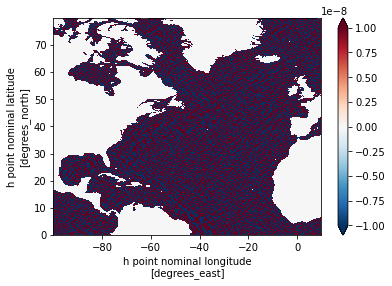

In [26]:
div_u = (grid.diff(ds['umo'] / (rho_0), 'X', boundary='fill')  + 
         grid.diff(ds['vmo'] / (rho_0), 'Y', boundary='fill') ) / ds_grid['areacello'] 

div_u.plot(vmin=-1e-8, vmax=1e-8, cmap='RdBu_r')

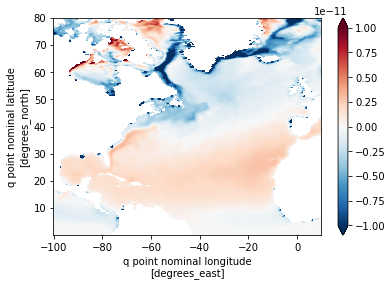

In [45]:
(BPT_g['Qm'] + BPT_g['fdhdt']).plot(vmin=-1e-11, vmax=1e-11, cmap='RdBu_r')

#### Plots

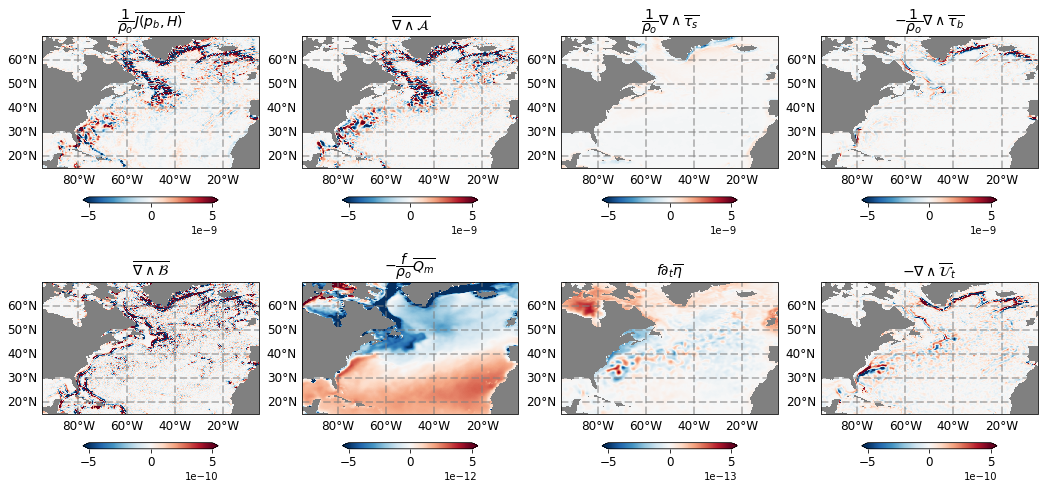

In [43]:
max_r = 5.e-9
lat_lon_ext = [-95., -5., 15., 70.]

grid1 = plt.GridSpec(2, 4, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[18,8])

#ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
#_ = plot_sec(ax, BPT_g['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
#                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta x \mathcal{V}$')

BPT1 = BPT_g['BPT'] + BPT_g['Curl_Cor'] + BPT_g['vmo_bv'] - BPT_g['Qm'] - BPT_g['fdhdt']
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_NL'] + BPT_g['Curl_remap'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taus'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_s}}$')

ax = fig.add_subplot(grid1[0, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taub'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$-\dfrac{1}{\rho_o}\nabla \wedge\overline{{\tau_b}}$')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_Hdiff'], vmin=-0.1*max_r, vmax=0.1*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{B}}$')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Qm'], vmin=-0.001*max_r, vmax=0.001*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \dfrac{f}{\rho_o}\overline{Q_m}$')

ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['fdhdt'], vmin=-0.0001*max_r, vmax=0.0001*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ f\partial_t\overline{\eta}$')

ax = fig.add_subplot(grid1[1, 3], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, - BPT_g['Curl_dudt'], vmin=-0.1*max_r, vmax=0.1*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$ - \nabla \wedge \overline{\mathcal{U}}_t$')

#ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
#_ = plot_sec(ax, BPT1 + BPT_g['Curl_NL'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
#                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='BPT + NL')

#tmp = (BPT1 + BPT_g['Curl_NL'] + BPT_g['Curl_remap'] + BPT_g['Qm'] + BPT_g['Curl_Hdiff'] + 
#       BPT_g['Curl_taub'] + BPT_g['Curl_taus'])
#ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
#im = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
#                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Sum all')

#cbar = fig.colorbar(im, ax=ax, shrink=0.95)
#plt.colorbar(format='%.1e', extend='both', shrink=0.6)

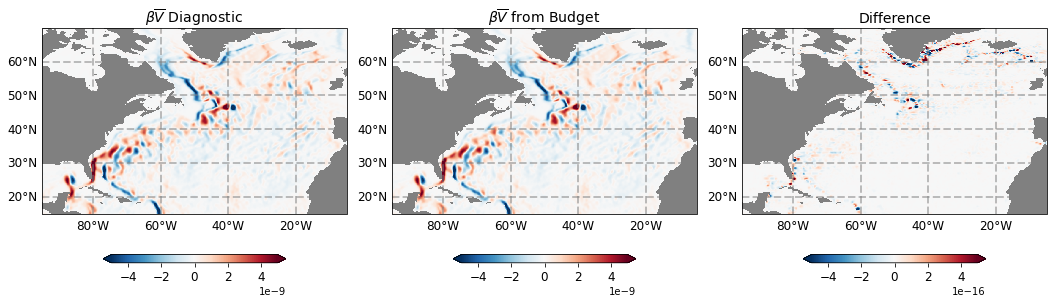

In [42]:
max_r = 5.e-9
lat_lon_ext = [-95., -5., 15., 70.]

grid1 = plt.GridSpec(1, 3, wspace=0.15, hspace=0.15)
fig = plt.figure(figsize=[18,5])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ Diagnostic')

tmp = (BPT1 + BPT_g['Curl_NL'] + BPT_g['Curl_remap'] + BPT_g['Curl_taus'] + BPT_g['Curl_taub'] +
      BPT_g['Curl_Hdiff'] + BPT_g['Qm'] + BPT_g['fdhdt'] - BPT_g['Curl_dudt'])
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\beta \overline{V}$ from Budget')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp - BPT_g['vmo_bv'], vmin=-1e-7*max_r, vmax=1e-7*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'Difference')

# Laplacian steps: 42; # Biharmonic steps: 4


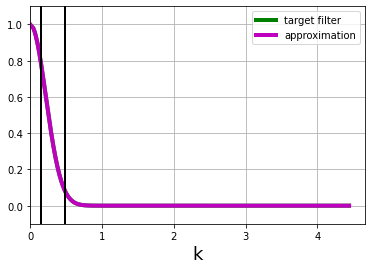

In [46]:
filter_fac = 16 # 1/8 --> 2 Deg

Lf_g = filter_fac/np.sqrt(6) 
N_g = 50
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

BPT_g1 = xr.Dataset() # new xarray dataset for Gaussian-filtered fields with Fixed (coarsening) Factor

fldlist = ['BPT','Curl_taus','Curl_taub','Curl_NL', 'Curl_remap', 'Curl_Cor',
           'Curl_Hdiff','vmo_bv','Qm','Curl_dudt', 'depth', 'fdhdt', 'div_u']
dims = ['yq', 'xq']

# Gaussian filter
for fld in fldlist: 
    
    dataBar = BPT[fld].copy() # Initialize the filtering process
    dataBar = dataBar * ds['areacello_bu']

    dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_c'], NL_g, sL_g, NB_g, sB_g, 
                             input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                             output_dtypes=[dataBar.dtype], dask='parallelized')

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(ds['wet_c'],dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds['areacello_bu'] # divide by cell area    

    BPT_g1[fld] = dataBar.copy()

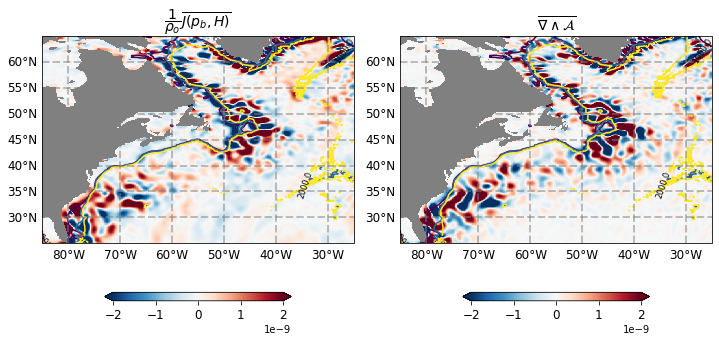

In [48]:
max_r = 2.e-9
lat_lon_ext = [-85., -25., 25., 65.]
#lat_lon_ext = [-65., -25., 45., 65.]

grid1 = plt.GridSpec(1, 2, wspace=0.15, hspace=0.15)
fig = plt.figure(figsize=[12,6])

BPT1 = BPT_g1['BPT'] + BPT_g1['Curl_Cor'] + BPT_g1['vmo_bv'] - BPT_g1['Qm'] - BPT_g1['fdhdt']
u = ds['umo'] / (ds.dyCu * colh_u * rho_0)

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT1, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\dfrac{1}{\rho_o}\overline{J(p_b, H)}$')

levels = [500., 1000., 2000.]
contours = plt.contour(ds.geolon_u, ds.geolat_u, depth_u, levels)
plt.clabel(contours, inline=True, fontsize=8, colors = 'k', fmt = '%4.1f')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g1['Curl_NL'] + BPT_g1['Curl_remap'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\overline{\nabla \wedge \mathcal{A}}$')

levels = [500., 1000., 2000.]
contours = plt.contour(ds.geolon_u, ds.geolat_u, depth_u, levels)
plt.clabel(contours, inline=True, fontsize=8, colors = 'k', fmt = '%4.1f')

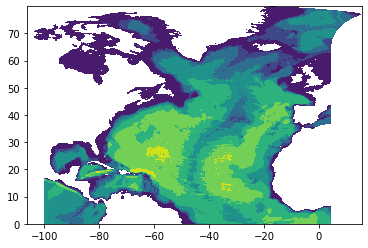

In [49]:
plt.contourf(ds.geolon_u, ds.geolat_u, depth_u)

In [100]:
ds.close()